In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import astropy.units as u

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

In [2]:
starname = "LHS 1140"

searchresults = lk.search_lightcurve(starname, author='SPOC')

In [3]:
searchresults

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,92226327,0.0
1,TESS Sector 30,2020,SPOC,20,92226327,0.0
2,TESS Sector 30,2020,SPOC,120,92226327,0.0


In [5]:
times, fluxes, texps = [], [], []

lc_file = lk.search_lightcurve(starname, sector=3, author="SPOC").download(flux_column="pdcsap_flux")
lc = lc_file.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0

times.append(time)
fluxes.append(flux)
texps.append(texp)

lc_file = lk.search_lightcurve(starname, sector=30, author="SPOC")[1].download(flux_column="pdcsap_flux")
lc = lc_file.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0

times.append(time)
fluxes.append(flux)
texps.append(texp)

In [6]:
#lk.search_lightcurve(starname, sector=30, author="SPOC")[0].download()


In [11]:
time = np.hstack([times[0], times[1]])
flux = np.hstack([fluxes[0], fluxes[1]])
np.array(texps)*24*60*60

array([120., 120.])

<Quantity 120. s>

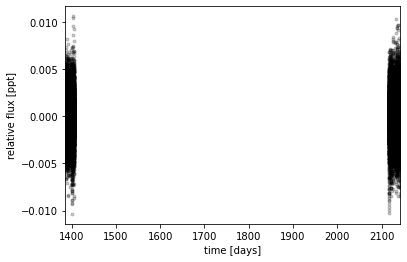

In [12]:
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

(texp*u.day).to(u.s)

In [22]:
# priors
%matplotlib
T0        = 2458389.29383-2457000
T0_unc    = 0.00082
P         = 3.77792
P_unc     = 0.00003
depth     = 0.00252
depth_unc = 0.00016
M_star = 0.191, 0.012
R_star = 0.2134, 0.0035


T0_b = 2458399.9303-2457000
P_b  = 24.73694

plt.plot(x, y, 'k.', alpha=0.3)
n = np.arange(0, 200)
t = T0 + n*P
plt.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
t_b = T0_b + n*P_b
plt.plot(t_b, [0 for i in t_b], '.', color='C3', zorder=1000)
plt.plot(2117.30156, 0, 'o', color='C4')
plt.xlim(x.min(), x.max())

Using matplotlib backend: Qt5Agg


(1385.941465292972, 2141.810111400904)

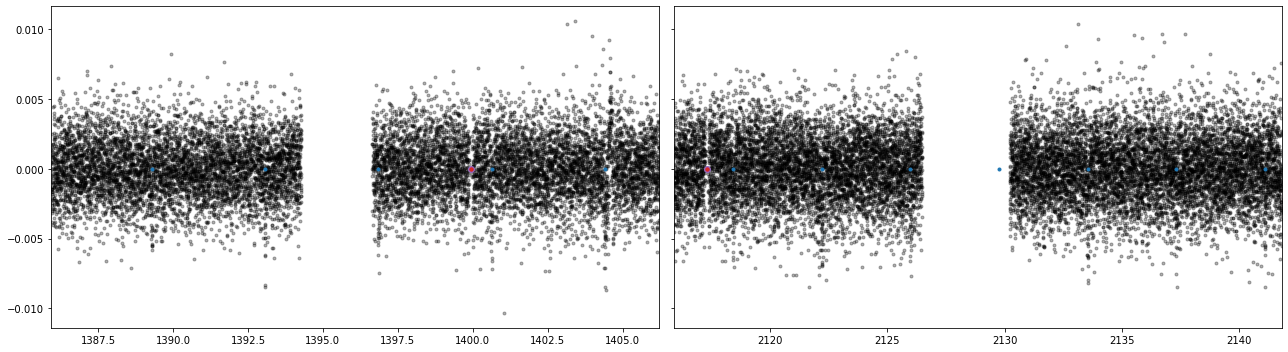

In [25]:
%matplotlib inline
# mask out planet b
mask = np.ones_like(time).astype(bool)
transitb = (time>2117.236) * (time<2117.3624)
mask[transitb]=False
transitb = (time>1399.8720) * (time<1399.9757)
mask[transitb]=False
x = np.ascontiguousarray(time, dtype=np.float64)[mask]
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)[mask]

mask = (time>1399.8720) * (time<1399.9757)

fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharey=True, )
for i in range(len(times)):
    ax[i].plot(x, y, 'k.', alpha=0.3)
    n = np.arange(0, 200)
    t = T0 + n*P
    ax[i].plot(t, [0 for i in t], '.', color='C0', zorder=1000)
    t_b = T0_b + n*P_b
    ax[i].plot(t_b, [0 for i in t_b], '.', color='C3', zorder=1000)
    ax[i].plot(2117.30156, 0, 'o', color='C4')
    ax[i].set_xlim(times[i].min(), times[i].max())
    
    ax[i].plot(t_b, [0 for i in t_b], '.', color='C3', zorder=1000)
    ax[i].plot(1399.9310, 0, 'o', color='C4')
    ax[i].set_xlim(times[i].min(), times[i].max())
    
fig.tight_layout()

In [26]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=0.001)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Luque (2019)
        #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
        #m_star = BoundedNormal(
        #    "m_star", mu=M_star[0], sd=M_star[1]
        #)
        #r_star = BoundedNormal(
        #    "r_star", mu=R_star[0], sd=R_star[1]
        #)
        m_star, r_star = M_star[0], R_star[0]

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=T0, sd=T0_unc)
        log_period = pm.Normal("log_period", mu=np.log(P), sd=P_unc)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(depth), sigma=depth_unc)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=0.1
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=0.01)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=0.1
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.Matern32Term(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


In [27]:
model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 133610.5320432712 -> 133644.6590022197
optimizing logp for variables: [log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: 133644.6590022197 -> 133644.6591459806
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 133644.6591459806 -> 133653.29765436667
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 133653.29765436667 -> 133661.28853103367
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 133661.28853103367 -> 133668.60711080124
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 133668.60711080124 -> 133670.1185131951
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 133670.1185131951 -> 133670.118785218
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 133670.118785218 -> 133670.1827625061
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 133670.1827625061 -> 133670.90391347074


0 1385.941465292972 1406.2189643114145
1 2115.891117243788 2141.810111400904


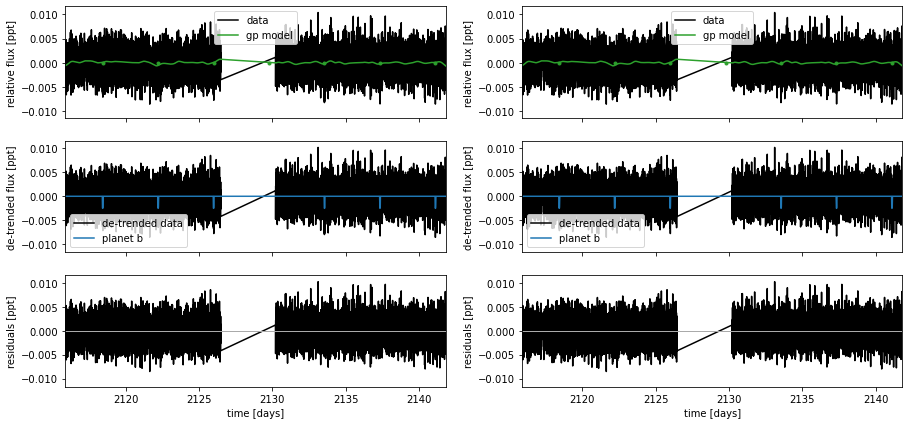

In [41]:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 2, figsize=(15, 7), sharex=True)

    for j in range(len(times)):
        print(j, times[j].min(), times[j].max())
        ax = axes[0,j]
        ax.plot(x[mask], y[mask], "k", label="data")
        gp_mod = extras["gp_pred"] + soln["mean"]
        ax.plot(x[mask], gp_mod, color="C2", label="gp model")
        ax.plot(t, [0 for i in t], '.', color='C2', zorder=1000)
        ax.legend(fontsize=10)
        ax.set_ylabel("relative flux [ppt]")
        
        ax = axes[1,j]
        ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
        for i, l in enumerate("b"):
            mod = extras["light_curves"][:, i]
            ax.plot(x[mask], mod, label="planet {0}".format(l))
        #ax.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
        ax.legend(fontsize=10, loc=3)
        ax.set_ylabel("de-trended flux [ppt]")

        ax = axes[2,j]
        mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
        ax.plot(x[mask], y[mask] - mod, "k")
        ax.axhline(0, color="#aaaaaa", lw=1)
        ax.set_ylabel("residuals [ppt]")
        ax.set_xlabel("time [days]")

        ax.set_xlim(times[j].min(), times[j].max())

    return fig


_ = plot_light_curve(map_soln0, extras0)

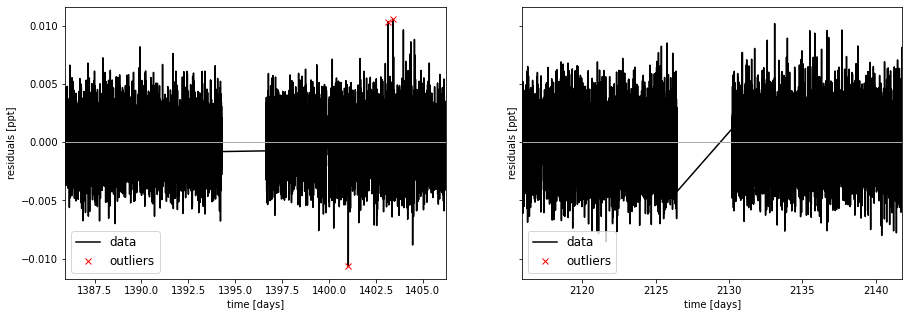

In [44]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
for j in range(len(times)):
    ax[j].plot(x, resid, "k", label="data")
    ax[j].plot(x[~mask], resid[~mask], "xr", label="outliers")
    ax[j].axhline(0, color="#aaaaaa", lw=1)
    ax[j].set_ylabel("residuals [ppt]")
    ax[j].set_xlabel("time [days]")
    ax[j].legend(fontsize=12, loc=3)
    ax[j].set_xlim(times[j].min(), times[j].max())

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 133689.53066351326 -> 133689.56846885374
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 133689.56846885374 -> 133689.56846885418
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 133689.56846885418 -> 133689.56849002794
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.56849002792 -> 133689.56849002792
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 133689.56849002794 -> 133689.5684959154
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.5684959154 -> 133689.5684959154
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 133689.5684959154 -> 133689.5684969296
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.5684969296 -> 133689.56849693094
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.56849693094 -> 133689.56849693094


0 1385.941465292972 1406.2189643114145
1 2115.891117243788 2141.810111400904


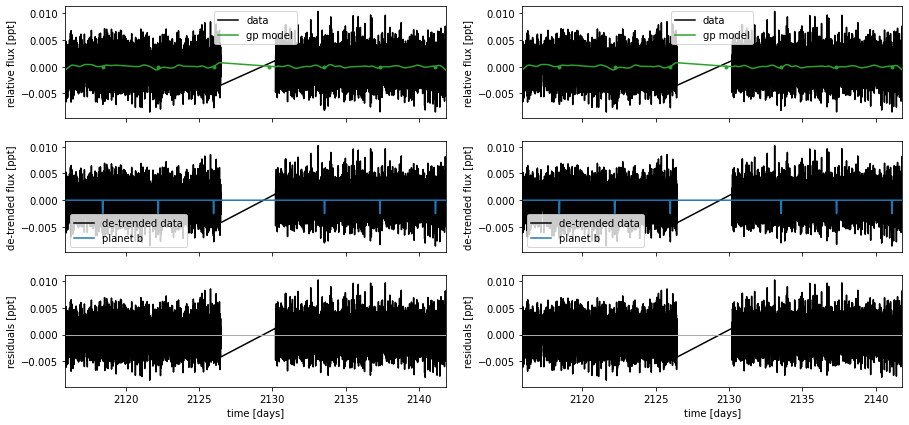

In [45]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

In [59]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=3000,
        start=map_soln,
        cores=1,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 4252 seconds.


In [60]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        #"r_star",
        #"m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,-1.467,1.109,-3.037,-0.116,0.017,0.013,4236.0,4577.0,1.0
ecc,0.195,0.159,0.000,0.499,0.004,0.003,1874.0,1630.0,1.0
r_pl,0.010,0.000,0.010,0.011,0.000,0.000,2223.0,1676.0,1.0
b,0.262,0.198,0.000,0.627,0.005,0.004,2024.0,1299.0,1.0
t0,1389.294,0.001,1389.293,1389.295,0.000,0.000,2517.0,2360.0,1.0
period,3.778,0.000,3.778,3.778,0.000,0.000,2030.0,1618.0,1.0
u_star[0],0.185,0.187,0.000,0.506,0.003,0.003,3572.0,2504.0,1.0
u_star[1],0.253,0.276,-0.170,0.832,0.005,0.003,3152.0,2873.0,1.0
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,6067.0,4034.0,1.0


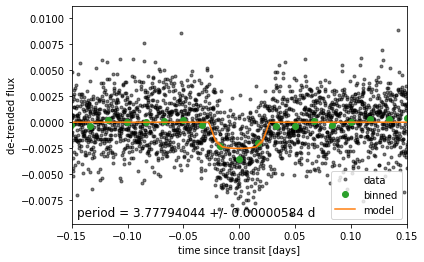

In [61]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", alpha=0.5, label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.8f} +/- {1:.8f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [62]:
print("Period:")
print("    ", np.median(flat_samps["period"]), '+/-', np.std(flat_samps["period"]))
print("T0:")
print("    ", np.median(flat_samps["t0"])+2457000, '+/-', np.std(flat_samps["t0"]))


Period:
     3.777939728053708 +/- <xarray.DataArray 'period' ()>
array(5.83523921e-06)
T0:
     2458389.2942323107 +/- <xarray.DataArray 't0' ()>
array(0.00062395)


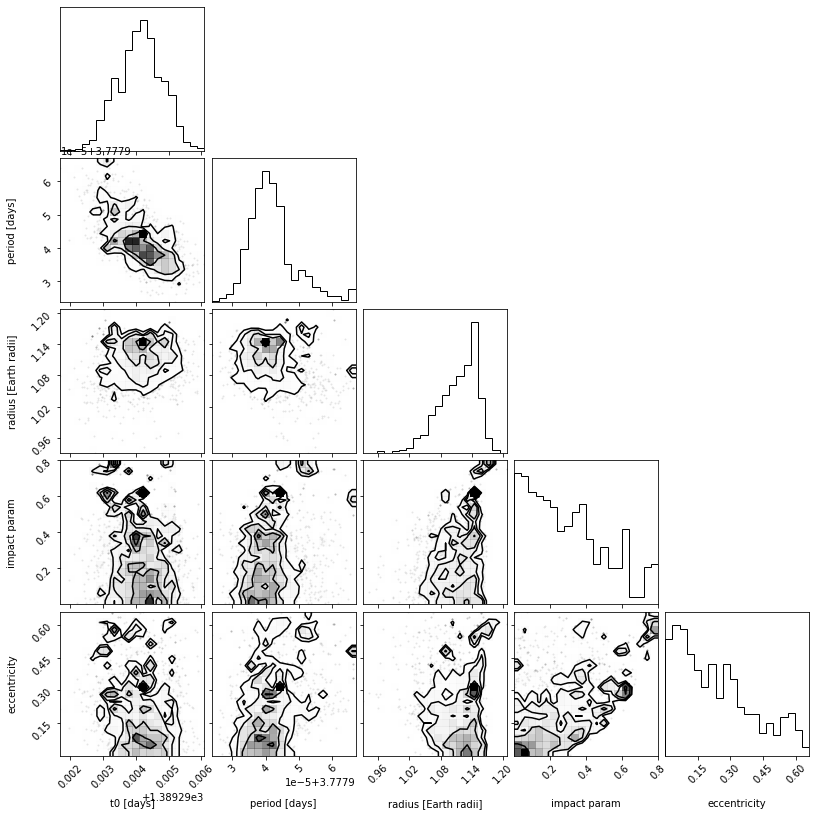

In [54]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["t0", "period", "r_earth", "b", "ecc"],
    labels=[
        "t0 [days]",
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)